# No traps

We try to verify that over-parameterised neural networks have few local minima of large loss. For this end, we train repeatedly neural networks with increasing number of hidden neurons. Hopefully, we'll see that neural networks with more neurons less often have a higher loss than the optimal loss.

As dataset we take Fashion MNIST, and we train the neural networks on just 5000 samples of the dataset, in order to decreases computation time.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

plt.style.use("seaborn-v0_8")

In [2]:
import tensorflow as tf

fashion = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion.load_data()
X=np.vstack([x_train,x_test])/255.0   # put all in one pick matrix and normalise
y=np.hstack([y_train,y_test])

train_size=5000
x_train, x_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [3]:
def run_net(hidden_size):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(hidden_size, activation='relu'),
      tf.keras.layers.Dense(10)
    ])    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss=loss_fn, metrics=['accuracy'],optimizer='SGD')
    callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `loss` is no longer improving
        monitor="loss",
        # "no longer improving" being defined as "no better than 1e-3"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 3 epochs"
        patience=3,
        verbose=0,
    )]
    history=model.fit(x_train, y_train, epochs=150, callbacks=callbacks,batch_size=5,verbose=0)
    return model,history

def get_stats_of_run(hidden_size):
    start=time.time()
    model,history=run_net(hidden_size)
    train_err=1-model.evaluate(x_train,y_train,verbose=0)[1]
    test_err=1-model.evaluate(x_test,y_test,verbose=0)[1]
    epochs=len(history.history["accuracy"])
    end=time.time()
    return [train_err,test_err,epochs,end-start]

# write results as they come in; allows to stop whenever it takes too long
# always append results
# if you want to overwrite previous results, run init_saving()
def save_results(stats):
    with open("local_min.dat", "a") as myfile:
        for stat in stats[:-1]:
            myfile.write("{},".format(stat))
        myfile.write("{}\n".format(stats[-1]))

def init_saving():
    with open("local_min.dat", "w") as myfile:
        myfile.write("# results of script local_minima\n")
        myfile.write("size_of_hidden_layer,training_error,test_error,number_of_epochs,training_time\n")

#init_saving()  ## needs to run once

In [61]:
hidden_sizes=[5,10,20,30,40]
#hidden_sizes=[100]
repeats=90

for _ in range(repeats):
    for hidden_size in hidden_sizes:
        stats=get_stats_of_run(hidden_size)
        stats.insert(0,hidden_size)
        save_results(stats)        

In [4]:
results=pd.read_csv("local_min.dat",comment="#")
results

,size_of_hidden_layer,training_error,test_error,number_of_epochs,training_time
0,5,0.0820,0.204538,82,49.327931
1,10,0.0742,0.187400,62,32.561689
2,20,0.0226,0.165354,90,46.253929
3,30,0.0564,0.180169,62,32.801035
4,40,0.0154,0.159292,77,40.554325
...,...,...,...,...,...
595,100,0.0244,0.160354,63,47.222870
596,100,0.0020,0.153938,96,69.660978
597,100,0.0020,0.153677,95,69.639056
598,100,0.0054,0.152862,88,64.194531


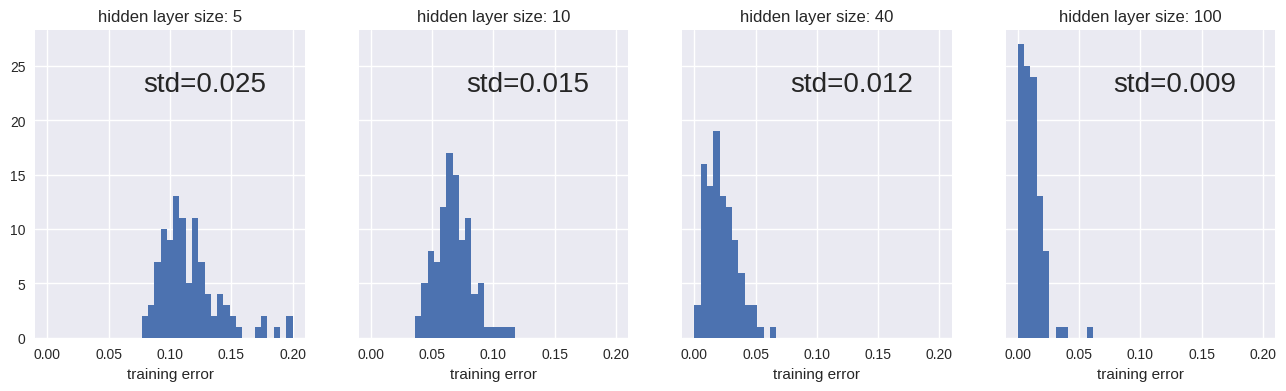

In [7]:
hidden_sizes=[5,10,40,100]
fig,axs=plt.subplots(1,4,figsize=(16,4),sharey=True)
bins=np.linspace(0,0.2,40)
for ax,hidden in zip(axs,hidden_sizes):
    df=results[results["size_of_hidden_layer"]==hidden]
    std=round(df["training_error"].std(),3)
    ax.annotate("std={}".format(std),(0.4,0.8),xycoords="axes fraction",fontsize=20)
    ax.hist(df["training_error"],bins=bins)
    ax.set_title("hidden layer size: {}".format(hidden))
    ax.set_xlabel("training error")

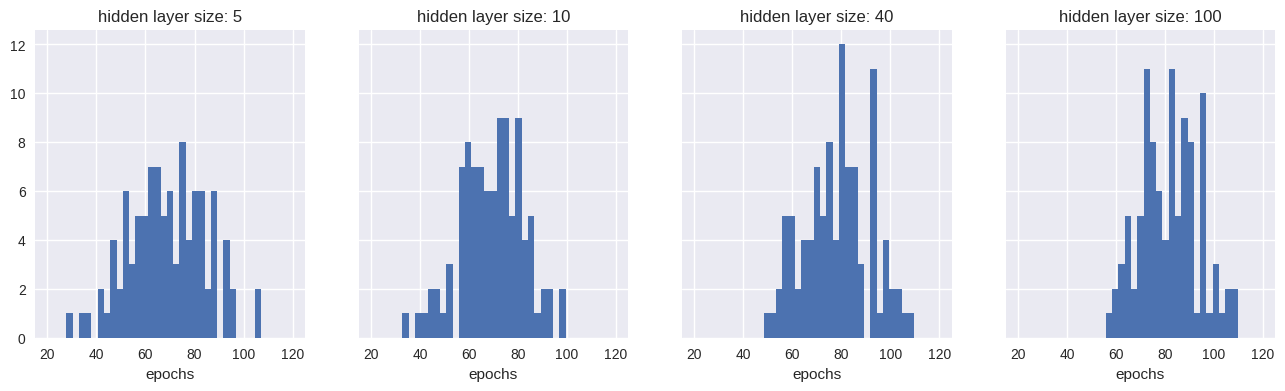

In [10]:
fig,axs=plt.subplots(1,4,figsize=(16,4),sharey=True)
bins=np.linspace(20,120,40)
for ax,hidden in zip(axs,hidden_sizes):
    df=results[results["size_of_hidden_layer"]==hidden]
    ax.hist(df["number_of_epochs"],bins=bins)
    ax.set_title("hidden layer size: {}".format(hidden))
    ax.set_xlabel("epochs")